In [1]:
# ============================================================
# MLDM Lab 2 — Supervised Learning (Template Notebook)
# Dataset: traffic_auto_daily.csv
# Task: classify daily traffic level (low / medium / high) for one PCTF
# Models: Bayes + Function-based + Tree-based + Meta-method (Ensemble)
# Metrics: confusion_matrix, classification_report, accuracy_score
# ============================================================

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# --- Required 4 categories of classifiers ---
from sklearn.naive_bayes import GaussianNB                    # Bayes
from sklearn.svm import SVC                                   # Function-based
from sklearn.tree import DecisionTreeClassifier               # Tree-based
from sklearn.ensemble import RandomForestClassifier           # Meta-method (ensemble)

In [2]:
# ============================================================
# 1) Load data + choose PCTF
# ============================================================

PCTF = "CAHUL"  # change to any PCTF you want (e.g., "LEUSENI", "SCULENI")

df = pd.read_csv("../data/traffic_auto_daily.csv")
df["data"] = pd.to_datetime(df["data"], errors="coerce")

df_one = df[df["pctf"] == PCTF].copy()

print("PCTF:", PCTF)
print("Rows:", len(df_one))
display(df_one.head())

PCTF: CAHUL
Rows: 1096


,pctf,data,intrare_day,iesire_day,total_day,car_in,car_out,bus_in,bus_out,light_trucks_in,light_trucks_out,trucks_in,trucks_out,zi_sapt,month,is_weekend
2192,CAHUL,2022-12-01,512,447,959,267,288,6,14,5,14,234,131,4,12,0
2193,CAHUL,2022-12-02,431,393,824,275,271,6,8,6,11,144,103,5,12,0
2194,CAHUL,2022-12-03,431,528,959,297,374,6,6,10,10,118,138,6,12,1
2195,CAHUL,2022-12-04,521,719,1240,360,592,11,12,6,8,144,107,7,12,1
2196,CAHUL,2022-12-05,452,496,948,268,310,15,9,10,13,159,164,1,12,0



Class distribution:
traffic_class
low       367
high      366
medium    363
Name: count, dtype: int64


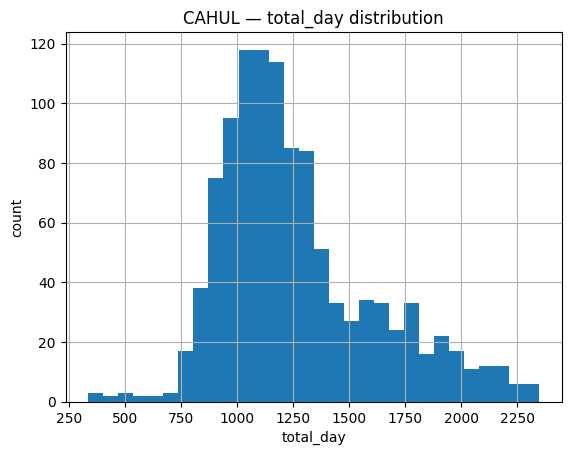

In [3]:
# ============================================================
# 2) Create TARGET (label) — traffic level classes
# ============================================================
# We must have a target variable for supervised learning.
# We'll create 3 classes based on total daily traffic.
#
# Option A (recommended): quantiles (balanced classes) using qcut
#   low / medium / high have ~similar counts
#
# Option B: fixed thresholds (domain-based) if you prefer

df_one["traffic_class"] = pd.qcut(
    df_one["total_day"],
    q=3,
    labels=["low", "medium", "high"]
)

print("\nClass distribution:")
print(df_one["traffic_class"].value_counts())

# Quick sanity check plot
plt.figure()
df_one["total_day"].hist(bins=30)
plt.title(f"{PCTF} — total_day distribution")
plt.xlabel("total_day")
plt.ylabel("count")
plt.show()

In [4]:
# ============================================================
# 3) Feature selection (X) and Target (y)
# ============================================================
# IMPORTANT: avoid leakage: DO NOT include total_day in X
# because traffic_class is created from total_day.

feature_cols = [
    "zi_sapt",
    "is_weekend",
    "intrare_day",
    "iesire_day",
    # If you want, you can add vehicle breakdown features:
    # "car_in", "car_out", "bus_in", "bus_out", "trucks_in", "trucks_out"
]

X = df_one[feature_cols].copy()
y = df_one["traffic_class"].copy()

print("\nFeatures:", feature_cols)
print("X shape:", X.shape, "| y shape:", y.shape)


Features: ['zi_sapt', 'is_weekend', 'intrare_day', 'iesire_day']
X shape: (1096, 4) | y shape: (1096,)


In [5]:
# ============================================================
# 4) Train/Test split
# ============================================================
# stratify=y keeps class distribution similar in train and test

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

print("\nTrain size:", len(X_train), "Test size:", len(X_test))
print("Train class distribution:\n", y_train.value_counts(normalize=True).round(3))
print("Test class distribution:\n", y_test.value_counts(normalize=True).round(3))


Train size: 822 Test size: 274
Train class distribution:
 traffic_class
low       0.335
high      0.335
medium    0.331
Name: proportion, dtype: float64
Test class distribution:
 traffic_class
low       0.336
medium    0.332
high      0.332
Name: proportion, dtype: float64


In [6]:
# ============================================================
# 5) Define models (one per required category)
# ============================================================
# Notes:
# - SVM is sensitive to feature scaling -> use StandardScaler
# - Tree and RandomForest do NOT require scaling, but scaling doesn't hurt
# - We'll use pipelines so all models are consistent and reproducible

models = {
    "Bayes (GaussianNB)": Pipeline([
        ("scaler", StandardScaler()),
        ("model", GaussianNB())
    ]),

    "Function-based (SVM)": Pipeline([
        ("scaler", StandardScaler()),
        ("model", SVC(kernel="rbf", C=2.0, gamma="scale", random_state=42))
    ]),

    "Tree-based (DecisionTree)": Pipeline([
        ("scaler", StandardScaler()),
        ("model", DecisionTreeClassifier(
            max_depth=6,
            random_state=42
        ))
    ]),

    "Meta-method (RandomForest)": Pipeline([
        ("scaler", StandardScaler()),
        ("model", RandomForestClassifier(
            n_estimators=200,
            random_state=42,
            max_depth=None,
            min_samples_leaf=2
        ))
    ])
}

In [7]:
# ============================================================
# 6) Train + Evaluate each model
# ============================================================

results = []

for name, clf in models.items():
    print("\n" + "="*60)
    print("Model:", name)

    # Train
    clf.fit(X_train, y_train)

    # Predict
    y_pred = clf.predict(X_test)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred, labels=["low", "medium", "high"])
    report = classification_report(y_test, y_pred, digits=3)

    print("\nAccuracy:", round(acc, 4))
    print("\nConfusion Matrix (rows=true, cols=pred):")
    print(pd.DataFrame(cm, index=["true_low","true_medium","true_high"],
                          columns=["pred_low","pred_medium","pred_high"]))

    print("\nClassification Report:")
    print(report)

    results.append({
        "Model": name,
        "Accuracy": acc
    })


Model: Bayes (GaussianNB)

Accuracy: 0.8942

Confusion Matrix (rows=true, cols=pred):
             pred_low  pred_medium  pred_high
true_low           85            7          0
true_medium         4           84          3
true_high           0           15         76

Classification Report:
              precision    recall  f1-score   support

        high      0.962     0.835     0.894        91
         low      0.955     0.924     0.939        92
      medium      0.792     0.923     0.853        91

    accuracy                          0.894       274
   macro avg      0.903     0.894     0.895       274
weighted avg      0.903     0.894     0.896       274


Model: Function-based (SVM)

Accuracy: 0.9745

Confusion Matrix (rows=true, cols=pred):
             pred_low  pred_medium  pred_high
true_low           92            0          0
true_medium         3           87          1
true_high           0            3         88

Classification Report:
              precision    

In [8]:
# Summary table
results_df = pd.DataFrame(results).sort_values("Accuracy", ascending=False)
print("\n" + "="*60)
print("Summary (sorted by Accuracy):")
display(results_df)


Summary (sorted by Accuracy):


,Model,Accuracy
1,Function-based (SVM),0.974453
3,Meta-method (RandomForest),0.963504
2,Tree-based (DecisionTree),0.952555
0,Bayes (GaussianNB),0.894161


In [ ]:
## Conclusions

In this laboratory work, several supervised learning classifiers were applied to predict
daily traffic levels (low, medium, high) for the CAHUL border crossing point.

Among the tested models, the SVM classifier achieved the highest accuracy, demonstrating
its ability to separate traffic regimes with non-linear decision boundaries.
Tree-based and ensemble methods also showed strong and stable performance, while
Naive Bayes performed worse due to its independence assumption.

The proposed approach can be practically used for daily traffic forecasting,
staff allocation, and operational planning at border crossing points.